Adapted in notebook time_series_gp_s+l_pulse_kernel_step_by_step:
- Use data file sim_pulse.lc
- Find the best kernel mixture for the stellar oscillations, step by step

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
## Plot the data

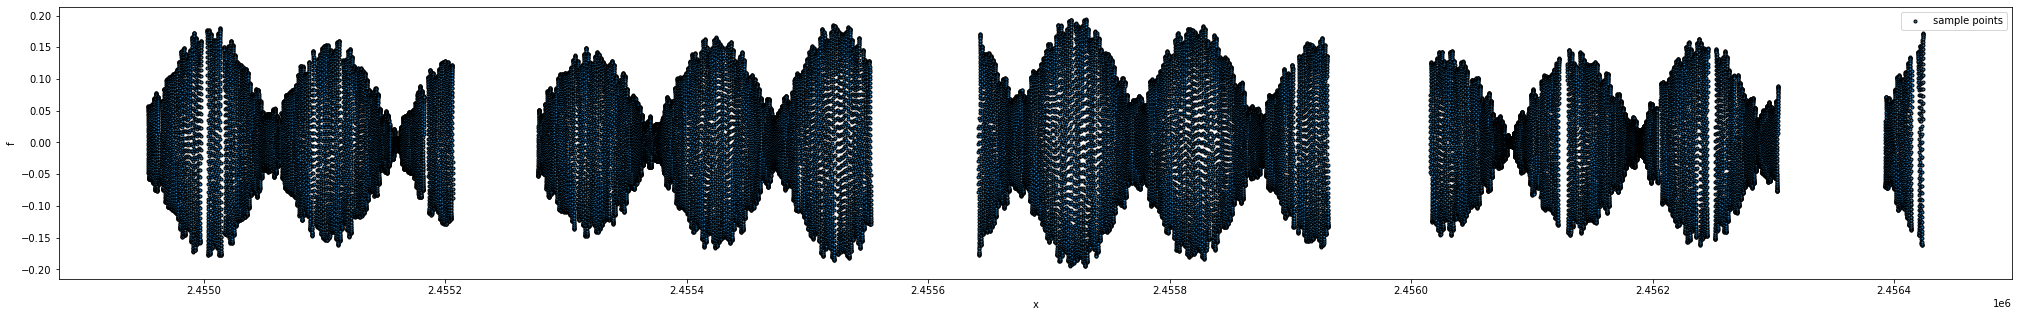

In [5]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

## Downsample

In [6]:
# Need to reduce further to 12800 points as N//4 doesn't work
X_part, Y_part = X[1::4][:12800], Y[1::4][:12800]
N_sampled = X_part.shape[0]   # Use a number that can be divided by 4. N//4
N_sampled

12800

In [7]:
X.min(), X.max()

(2454953.5392269692, 2456424.001734486)

In [8]:
X[1::4].min(), X[1::4].max()

(2454953.5596612184, 2456423.960865978)

Select a subset for training the kernel

In [9]:
N_part = N_sampled

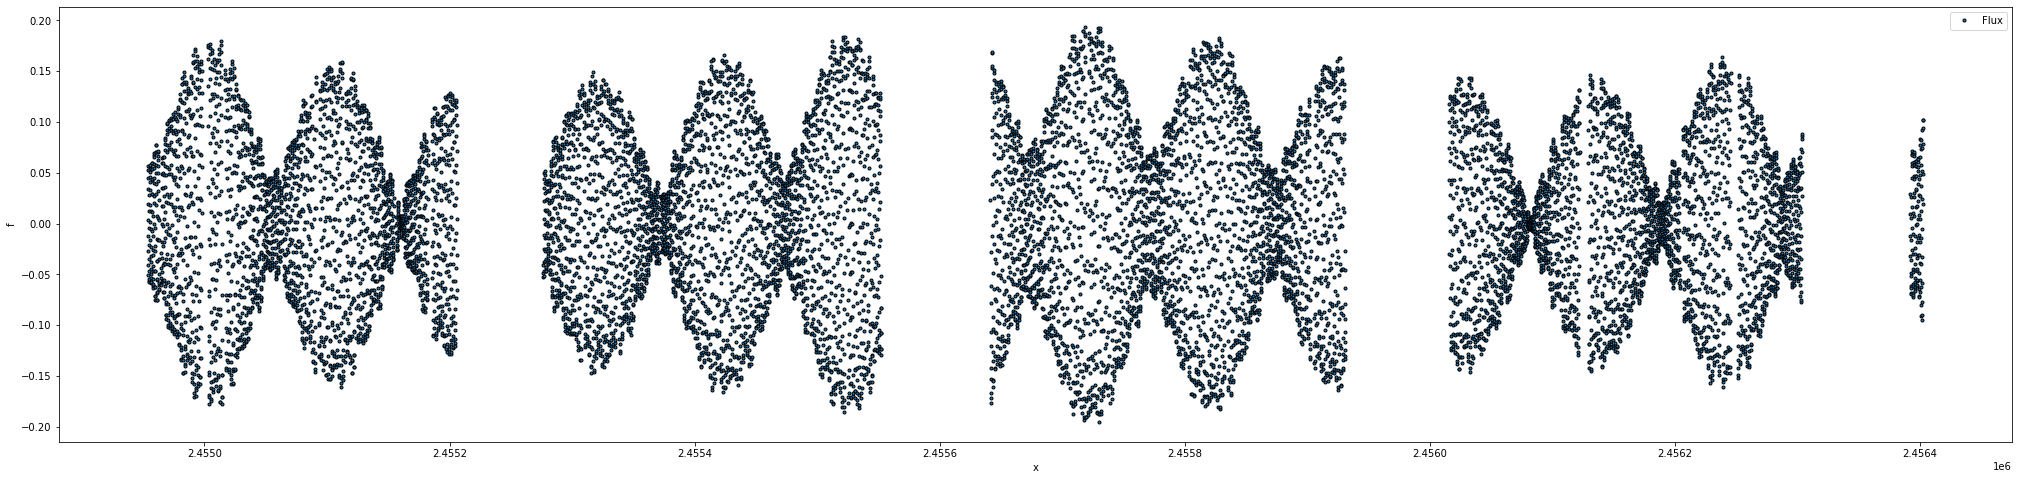

In [10]:
# Setup our figure environment
plt.figure(figsize=(35, 8))

# Plot observations
plt.plot(X_part, Y_part, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [11]:
def plot_kernel_samples(covariance_matrix, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    Y_sample = covariance_matrix.sample(nr_of_samples)
    N = cov_matrix.W.shape[0]
    for i in range(nr_of_samples):
        plt.plot(range(N), Y_sample[i])

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [12]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

In [13]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [14]:
# Initialize the S+LEAF model
cov_matrix = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=200000.36505))

In [15]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix, params_to_fit))

In [16]:
params_to_fit

['sho.sig']

In [17]:
xbest

array([9.71454749e-01, 8.06085063e+00, 2.00000365e+05])

In [18]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
mu_part_smooth, var_part_smooth = cov_matrix.conditional(Y_part, X_part_smooth, calc_cov='diag')

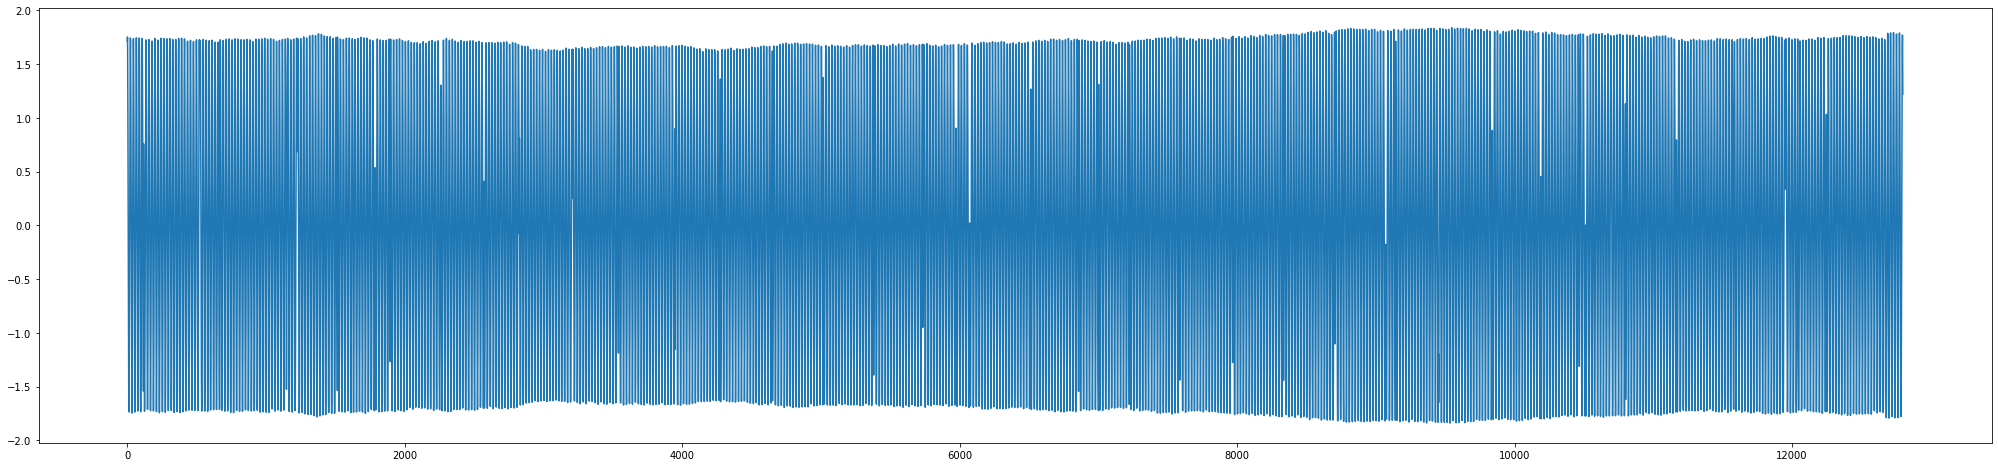

In [19]:
plot_kernel_samples(cov_matrix, 1)

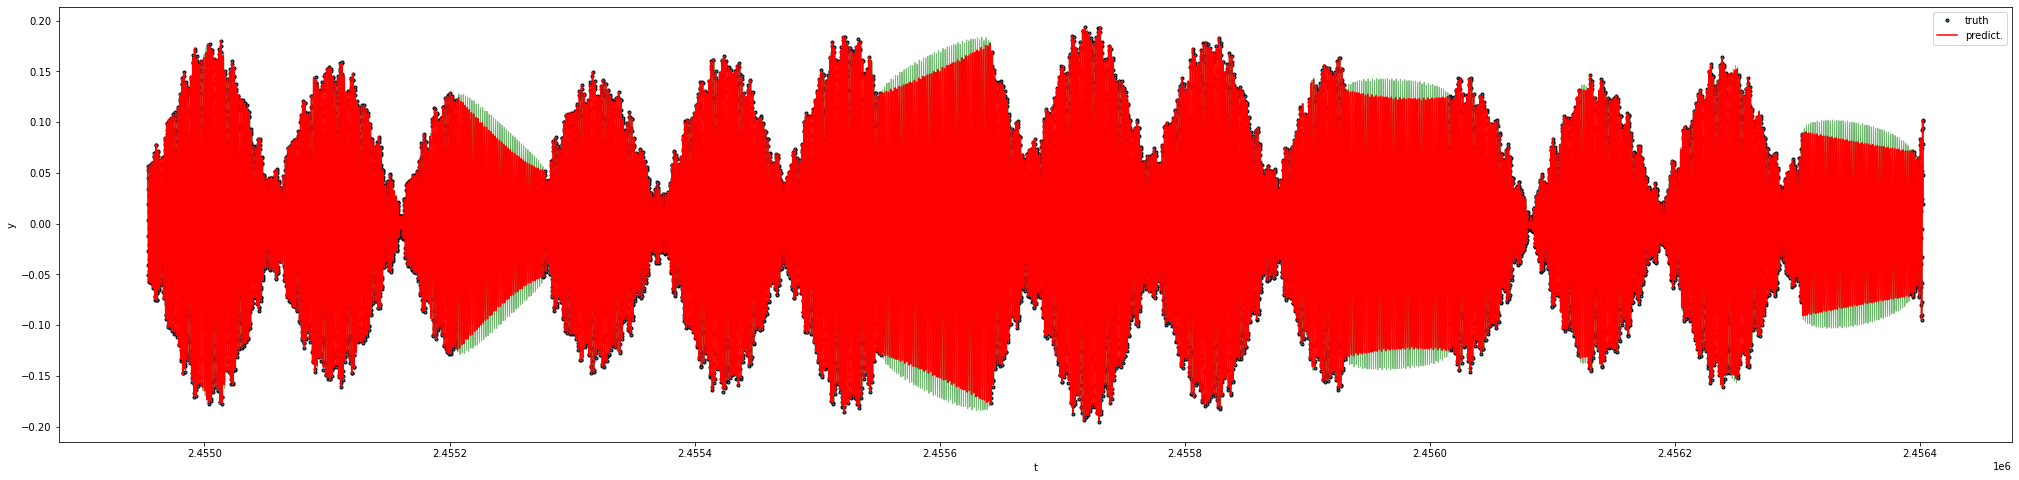

In [20]:
plot_series(X_part, Y_part, X_part_smooth, mu_part_smooth, var_part_smooth)

## Explore the parameters of the fitted model

In [21]:
cov_matrix.param

['sho.sig', 'sho.P0', 'sho.Q']

In [22]:
cov_matrix.get_param('sho.sig'), cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho.Q')

(0.9714547491750535, 1.7627357659086902, 200000.36505)

## Model Evaluation

RMSE

In [23]:
mu_part, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

np.sqrt(np.nanmean((mu_part-Y_part)**2))

2.8044266573875085e-12

RMSE per x

In [24]:
np.sqrt(np.nanmean((mu_part-Y_part)**2))/N_part

2.1909583260839911e-16

# Residuals
Calculate the residuals after fitting the model for our next step.

In [25]:
resid1_part = Y_part - mu_part

In [26]:
Y_part, mu_part, resid1_part

(array([0.0567645 , 0.05314041, 0.04529797, ..., 0.07804633, 0.04827558,
        0.0193355 ]),
 array([0.0567645 , 0.05314041, 0.04529797, ..., 0.07804633, 0.04827558,
        0.0193355 ]),
 array([ 4.08284517e-14, -5.09543796e-13, -1.21361254e-13, ...,
        -2.74696932e-13,  4.44158599e-13,  8.58740162e-13]))

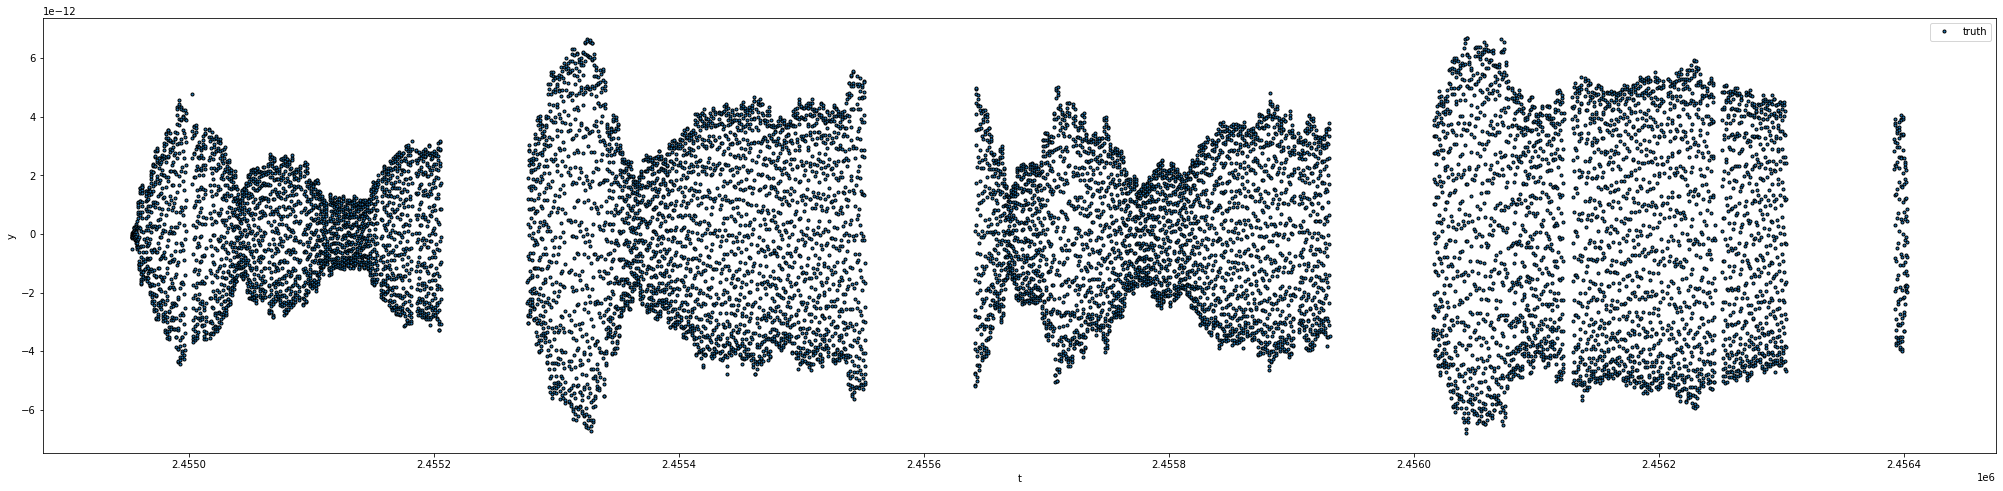

In [27]:
plot_series(X_part, resid1_part)

The residuals are very small compared to Y (e-14).
Yet, there is still a periodic signal, this is not stationary yet

## Stage 2: Model the residuals

In [28]:
# Initialize the S+LEAF model
cov_matrix2 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.0000000004314, P0=1.7937, Q=200000.36505))

In [29]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res2,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix2.get_param(), args=(resid1_part, cov_matrix2, params_to_fit))
cov_matrix2.set_param(xbest_res2, params_to_fit)

In [30]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res2_part_smooth, var_res2_part_smooth = cov_matrix2.conditional(resid1_part, X_part_smooth, calc_cov='diag')

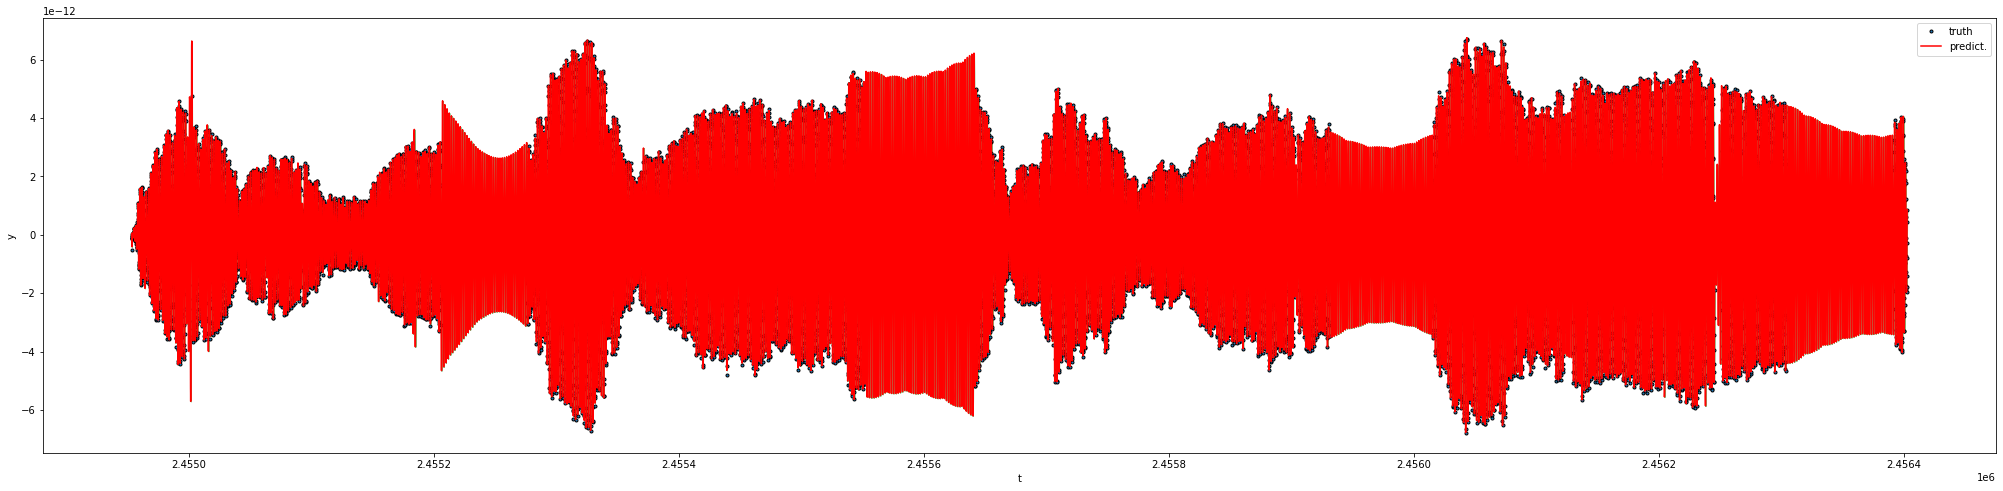

In [31]:
plot_series(X_part, resid1_part, X_part_smooth, mu_res2_part_smooth, 0)

In [32]:
cov_matrix2.get_param('sho.sig'), cov_matrix2.get_param('sho.P0'), cov_matrix2.get_param('sho.Q')

(-3.549922389415671e-10, 1.7937, 200000.36505)

In [33]:
mu_res2_part, _ = cov_matrix2.conditional(resid1_part, X_part, calc_cov='diag')
resid2_part = resid1_part - mu_res2_part
resid1_part, mu_res2_part, resid2_part

(array([ 4.08284517e-14, -5.09543796e-13, -1.21361254e-13, ...,
        -2.74696932e-13,  4.44158599e-13,  8.58740162e-13]),
 array([ 4.08284511e-14, -5.09543799e-13, -1.21361253e-13, ...,
        -2.74696868e-13,  4.44158652e-13,  8.58740203e-13]),
 array([ 6.03862042e-22,  2.54109884e-21, -9.52912066e-22, ...,
        -6.39509875e-20, -5.35748339e-20, -4.05517023e-20]))

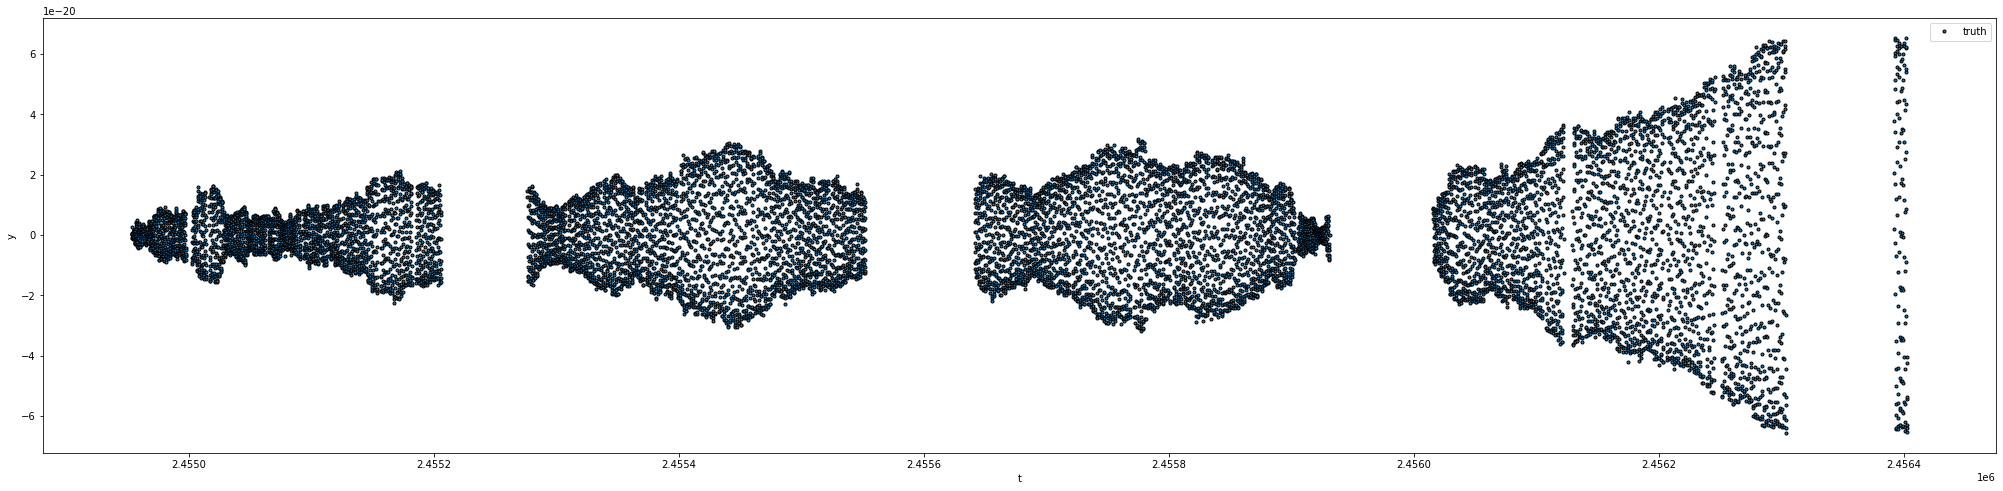

In [34]:
plot_series(X_part, resid2_part)

## Stage 3: Model the residuals

In [35]:
# Initialize the S+LEAF model
cov_matrix3 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.0000000000000000004314, P0=1.7590, Q=200000.36505))

In [36]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res3,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix3.get_param(), args=(resid2_part, cov_matrix3, params_to_fit))
cov_matrix3.set_param(xbest_res3, params_to_fit)

In [37]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res3_part_smooth, var_res3_part_smooth = cov_matrix3.conditional(resid2_part, X_part_smooth, calc_cov='diag')

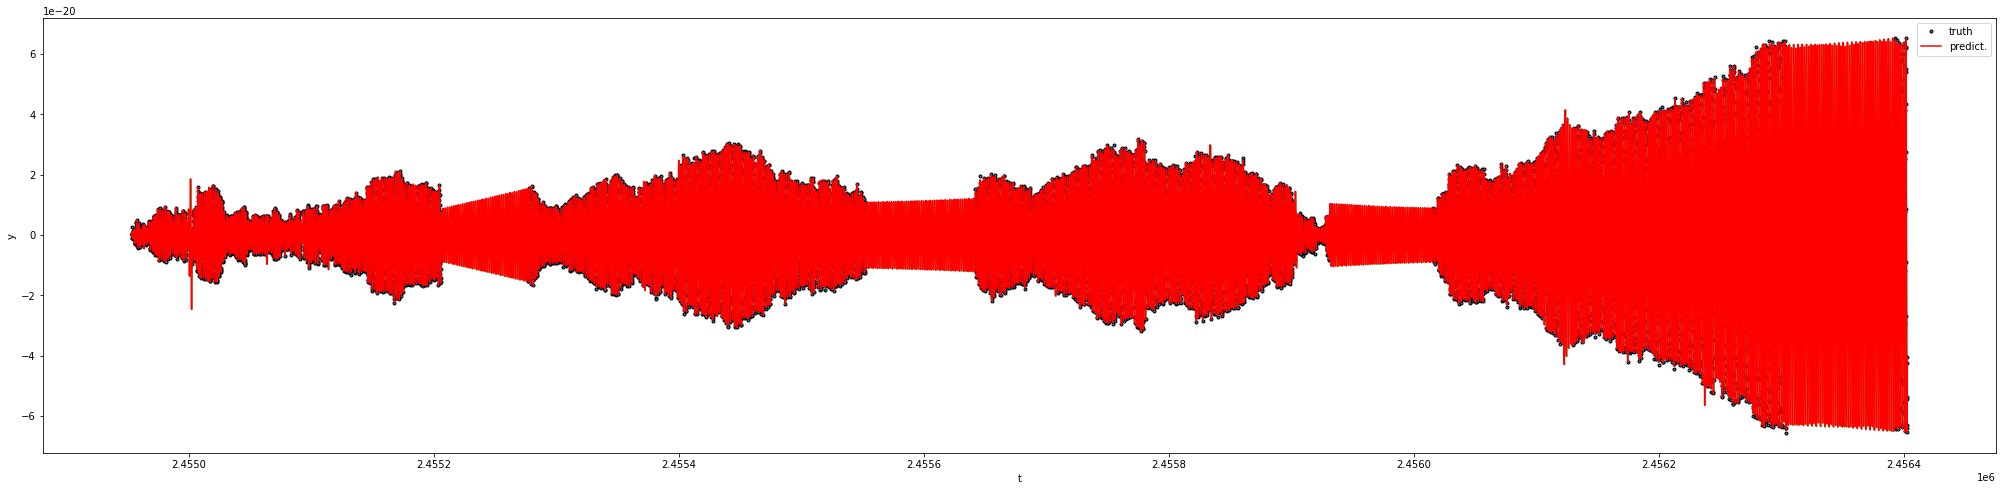

In [38]:
plot_series(X_part, resid2_part, X_part_smooth, mu_res3_part_smooth, 0)

In [39]:
cov_matrix3.get_param('sho.sig'), cov_matrix3.get_param('sho.P0'), cov_matrix3.get_param('sho.Q')

(-4.314e-19, 1.759, 200000.36505)

In [40]:
mu_res3_part, _ = cov_matrix3.conditional(resid2_part, X_part, calc_cov='diag')
resid3_part = resid2_part - mu_res3_part
resid2_part, mu_res3_part, resid3_part

(array([ 6.03862042e-22,  2.54109884e-21, -9.52912066e-22, ...,
        -6.39509875e-20, -5.35748339e-20, -4.05517023e-20]),
 array([ 6.03862042e-22,  2.54109883e-21, -9.52912066e-22, ...,
        -6.39509877e-20, -5.35748340e-20, -4.05517023e-20]),
 array([ 2.57086821e-31,  1.42981039e-29,  0.00000000e+00, ...,
         1.45150407e-28,  5.04870979e-29, -2.28769663e-29]))

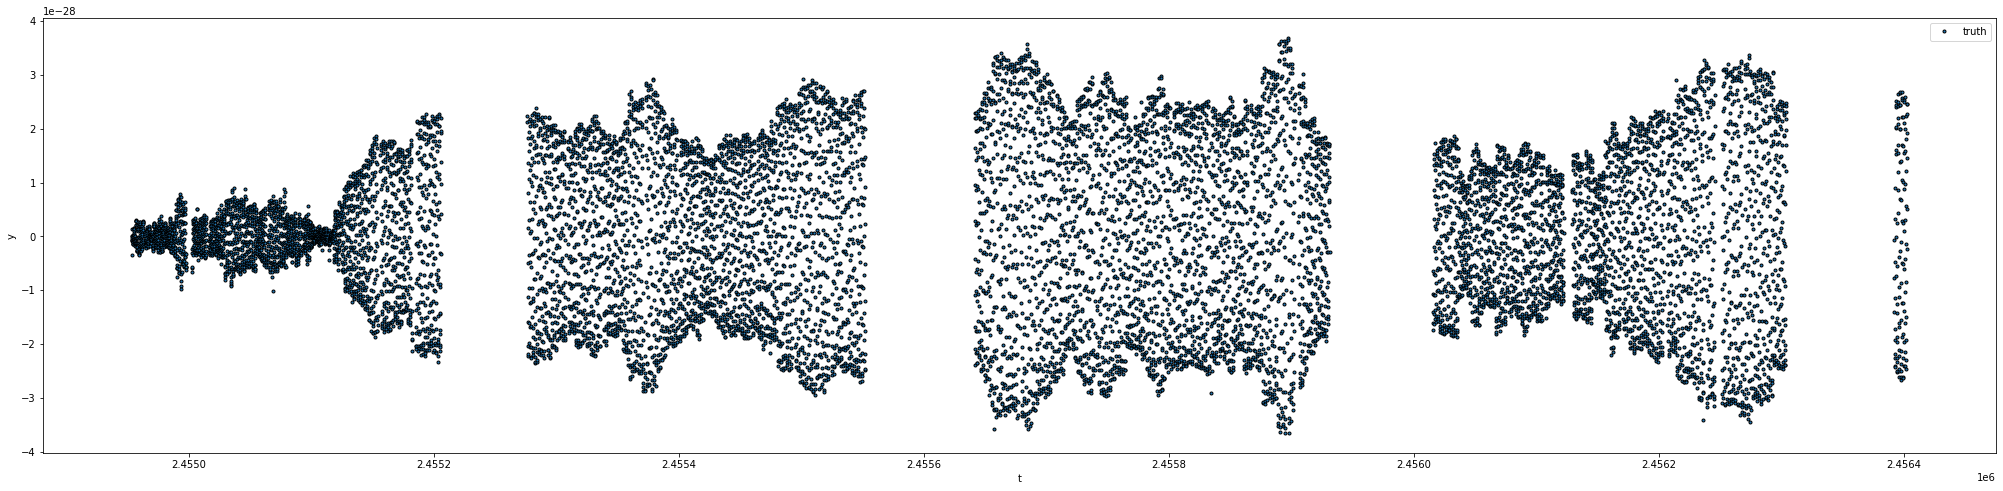

In [41]:
plot_series(X_part, resid3_part)

## Stage 4: Model the residuals

In [42]:
# Initialize the S+LEAF model
cov_matrix4 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.000000000004314, P0=1.7474, Q=200000.36505))

In [43]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res4,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix4.get_param(), args=(resid3_part, cov_matrix4, params_to_fit))
cov_matrix4.set_param(xbest_res4, params_to_fit)

In [44]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res4_part_smooth, var_res4_part_smooth = cov_matrix4.conditional(resid3_part, X_part_smooth, calc_cov='diag')

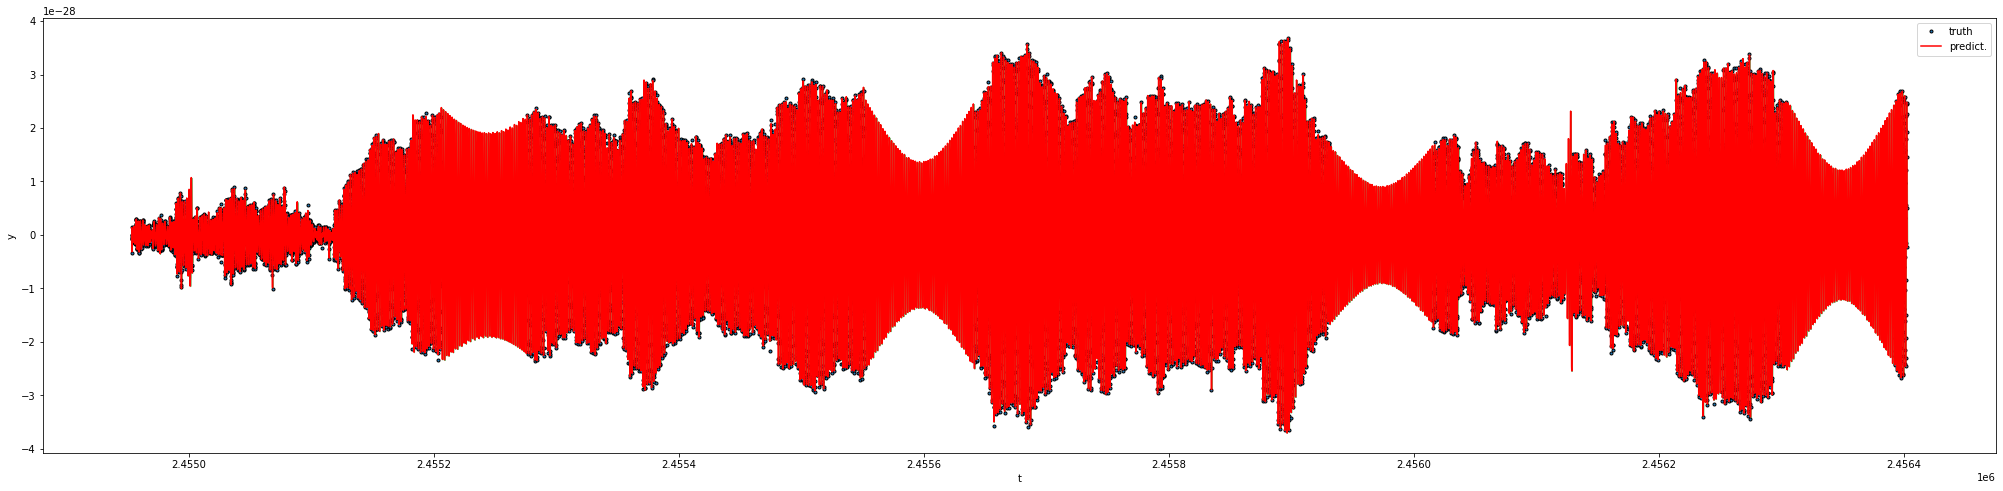

In [45]:
plot_series(X_part, resid3_part, X_part_smooth, mu_res4_part_smooth, 0)

In [46]:
cov_matrix4.get_param('sho.sig'), cov_matrix4.get_param('sho.P0'), cov_matrix4.get_param('sho.Q')

(-4.314e-12, 1.7474, 200000.36505)

In [47]:
mu_res4_part, _ = cov_matrix4.conditional(resid3_part, X_part, calc_cov='diag')
resid4_part = resid3_part - mu_res4_part
resid3_part, mu_res4_part, resid4_part

(array([ 2.57086821e-31,  1.42981039e-29,  0.00000000e+00, ...,
         1.45150407e-28,  5.04870979e-29, -2.28769663e-29]),
 array([ 2.57086810e-31,  1.42981039e-29, -6.31828214e-38, ...,
         1.45150405e-28,  5.04870949e-29, -2.28769699e-29]),
 array([1.16236362e-38, 8.81620763e-39, 6.31828214e-38, ...,
        2.02185028e-36, 3.05628531e-36, 3.60876766e-36]))

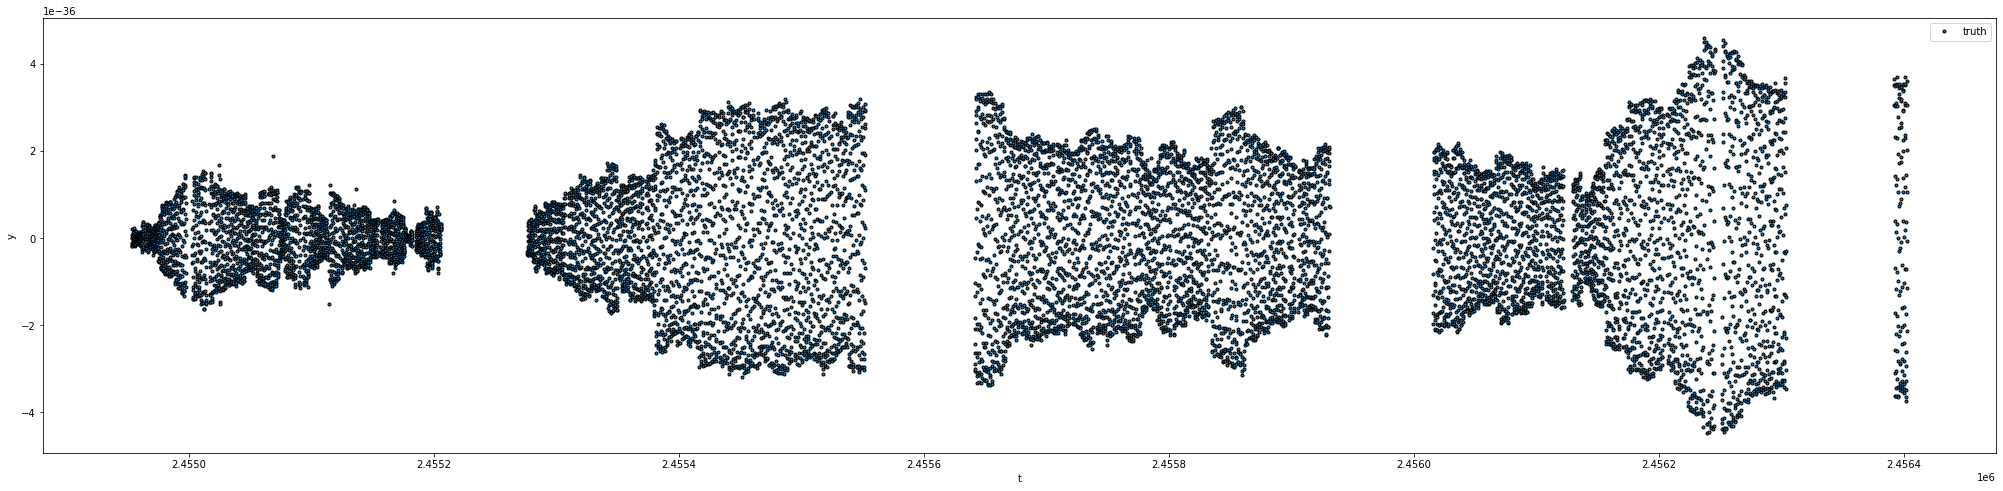

In [48]:
plot_series(X_part, resid4_part)

## Stage 5 Model the residuals

In [49]:
# Initialize the S+LEAF model
cov_matrix5 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.000000000004314, P0=0.8889, Q=200000.36505))

In [50]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res5,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix5.get_param(), args=(resid4_part, cov_matrix5, params_to_fit))
cov_matrix5.set_param(xbest_res5, params_to_fit)

In [51]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res5_part_smooth, var_res5_part_smooth = cov_matrix5.conditional(resid4_part, X_part_smooth, calc_cov='diag')

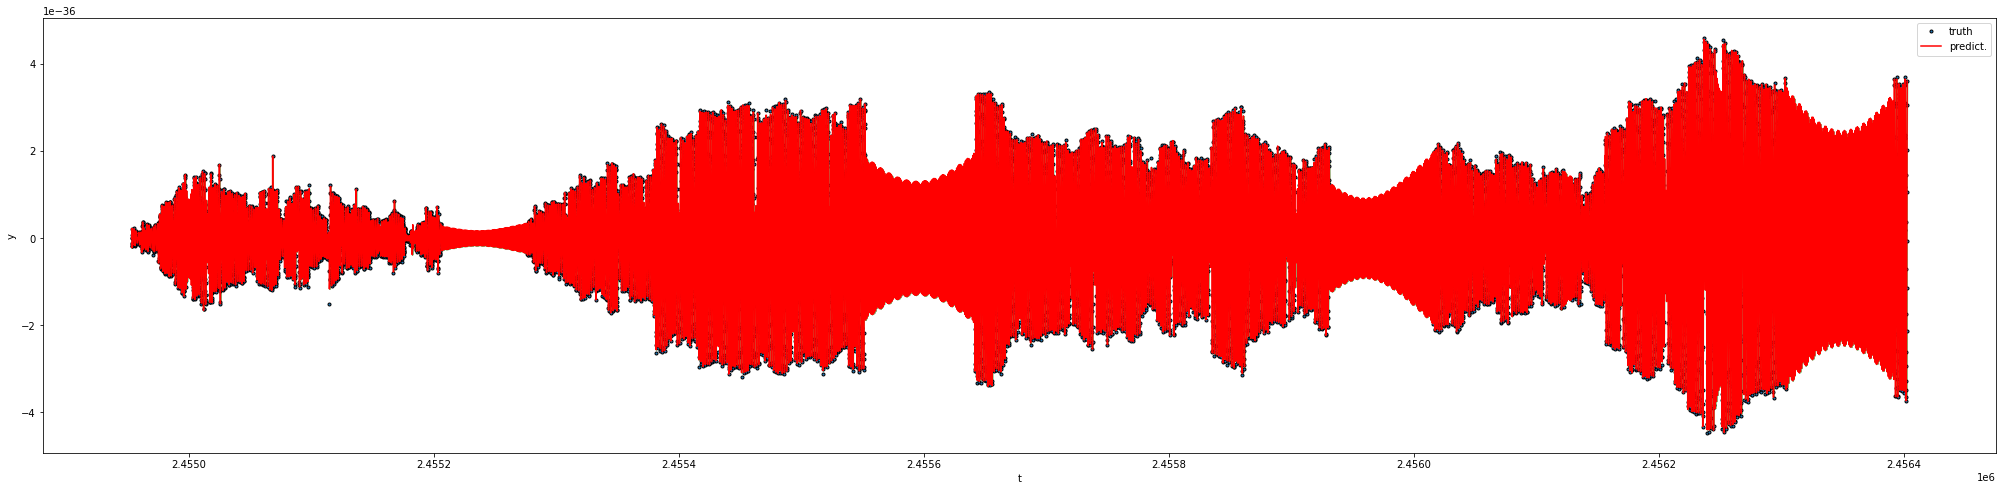

In [52]:
plot_series(X_part, resid4_part, X_part_smooth, mu_res5_part_smooth, 0)

In [53]:
cov_matrix5.get_param('sho.sig'), cov_matrix5.get_param('sho.P0'), cov_matrix5.get_param('sho.Q')

(-4.314e-12, 0.8889, 200000.36505)

In [54]:
mu_res5_part, _ = cov_matrix5.conditional(resid4_part, X_part, calc_cov='diag')
resid5_part = resid4_part - mu_res5_part
resid4_part, mu_res5_part, resid5_part

(array([1.16236362e-38, 8.81620763e-39, 6.31828214e-38, ...,
        2.02185028e-36, 3.05628531e-36, 3.60876766e-36]),
 array([1.16236362e-38, 8.81620765e-39, 6.31828215e-38, ...,
        2.02185029e-36, 3.05628531e-36, 3.60876766e-36]),
 array([ 9.18824207e-49, -2.18952885e-47, -1.31371731e-46, ...,
        -3.93020429e-45, -1.25897909e-45,  1.18234558e-45]))

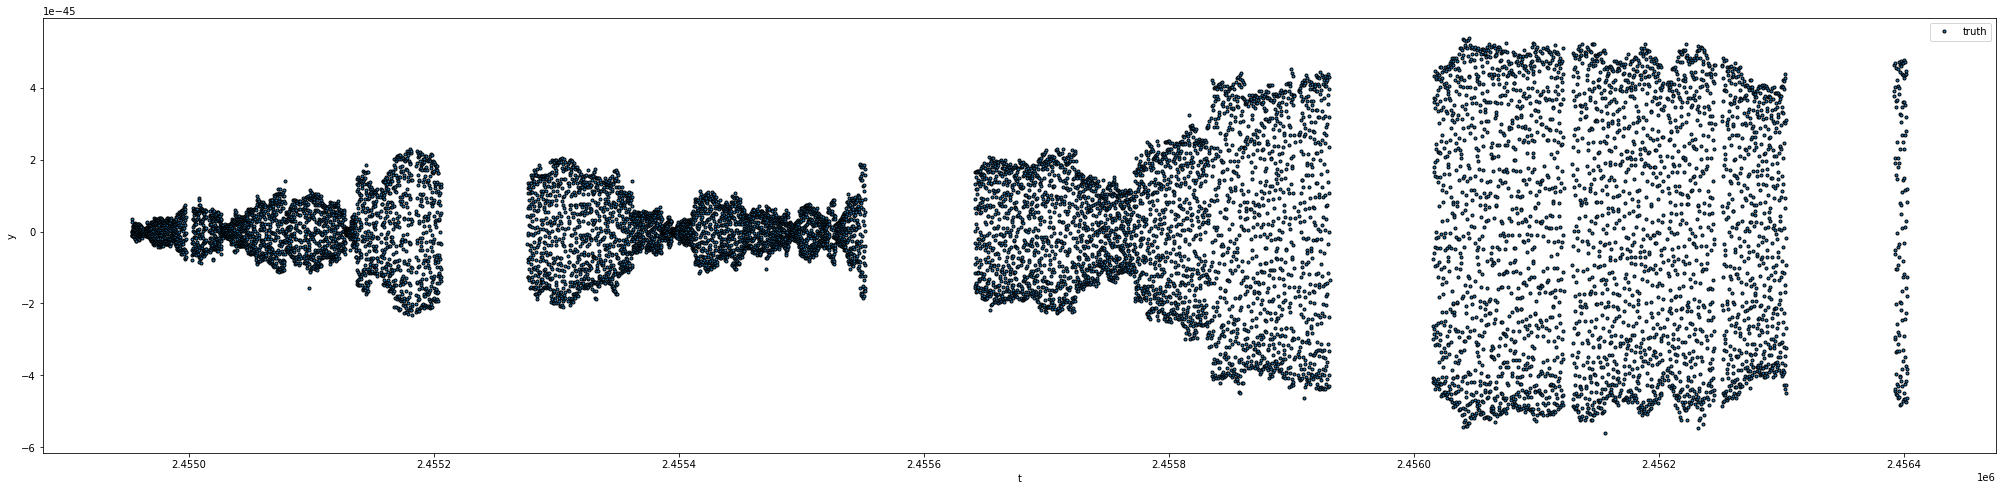

In [55]:
plot_series(X_part, resid5_part)